# Preprocessing and visualization of Dataset #1: Adults

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

In [2]:
# 1. Load the datasets into Pandas dataframes
names1=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'over-50K']
dataset1_train = pd.read_csv('adult_train.csv', index_col=False, names=names1, sep=',\s', na_values=['?'], engine='python')
dataset1_test = pd.read_csv('adult_test.csv', index_col=False, names=names1, sep=',\s', na_values=['?', 'nan', '|1x3 Cross validator'], engine='python')

print(dataset1_train.shape)

(32561, 15)


## Clean the data

In [3]:
# Remove instances with missing/invalid data entries
dataset1_train.dropna(axis=0, how='any', inplace=True)
dataset1_test.dropna(axis=0, how='any', inplace=True)
print(dataset1_train.shape)

(30162, 15)


In [4]:
# Encode Over 50K as 1
dataset1_train['over-50K'] = dataset1_train['over-50K'].map({'>50K': 1, '<=50K': 0})
dataset1_test['over-50K'] = dataset1_test['over-50K'].map({'>50K': 1, '<=50K': 0})

# Encode Male as 1
dataset1_train['sex'] = dataset1_train['sex'].map({'Male': 1, 'Female': 0})
dataset1_test['sex'] = dataset1_test['sex'].map({'Male': 1, 'Female': 0})

In [5]:
print(dataset1_train['native-country'].describe()) 

count             30162
unique               41
top       United-States
freq              27504
Name: native-country, dtype: object


Since 91% of native-country data is US, we will categorize this column as "US" and "non-US".

In [6]:
# Encode US as 1 and non-US as 0
dataset1_train['native-country'] = np.where(dataset1_train['native-country']=='United-States', 1, 0)
dataset1_test['native-country'] = np.where(dataset1_test['native-country']=='United-States', 1, 0)

In [7]:
# Correlation
correlations = dataset1_train.corr(method="pearson")
print(correlations)

                     age    fnlwgt  education-num       sex  capital-gain  \
age             1.000000 -0.076511       0.043526  0.081993      0.080154   
fnlwgt         -0.076511  1.000000      -0.044992  0.025362      0.000422   
education-num   0.043526 -0.044992       1.000000  0.006157      0.124416   
sex             0.081993  0.025362       0.006157  1.000000      0.048814   
capital-gain    0.080154  0.000422       0.124416  0.048814      1.000000   
capital-loss    0.060165 -0.009750       0.079646  0.047011     -0.032229   
hours-per-week  0.101599 -0.022886       0.152522  0.231268      0.080432   
native-country  0.016259 -0.083390       0.127207 -0.003006      0.012375   
over-50K        0.241998 -0.008957       0.335286  0.216699      0.221196   

                capital-loss  hours-per-week  native-country  over-50K  
age                 0.060165        0.101599        0.016259  0.241998  
fnlwgt             -0.009750       -0.022886       -0.083390 -0.008957  
education-

From the above correlations, we can interpret that 'fnlgwt' and 'native-country' are not relevant to predicting the salary as their correlation is below 0.09.

In [8]:
# Remove uncorrelated columns
dataset1_train = dataset1_train.drop(columns=['fnlwgt', 'native-country'])
dataset1_test = dataset1_test.drop(columns=['fnlwgt', 'native-country'])

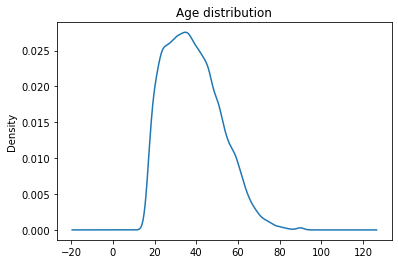

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>],
       [<AxesSubplot:title={'center':'over-50K'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

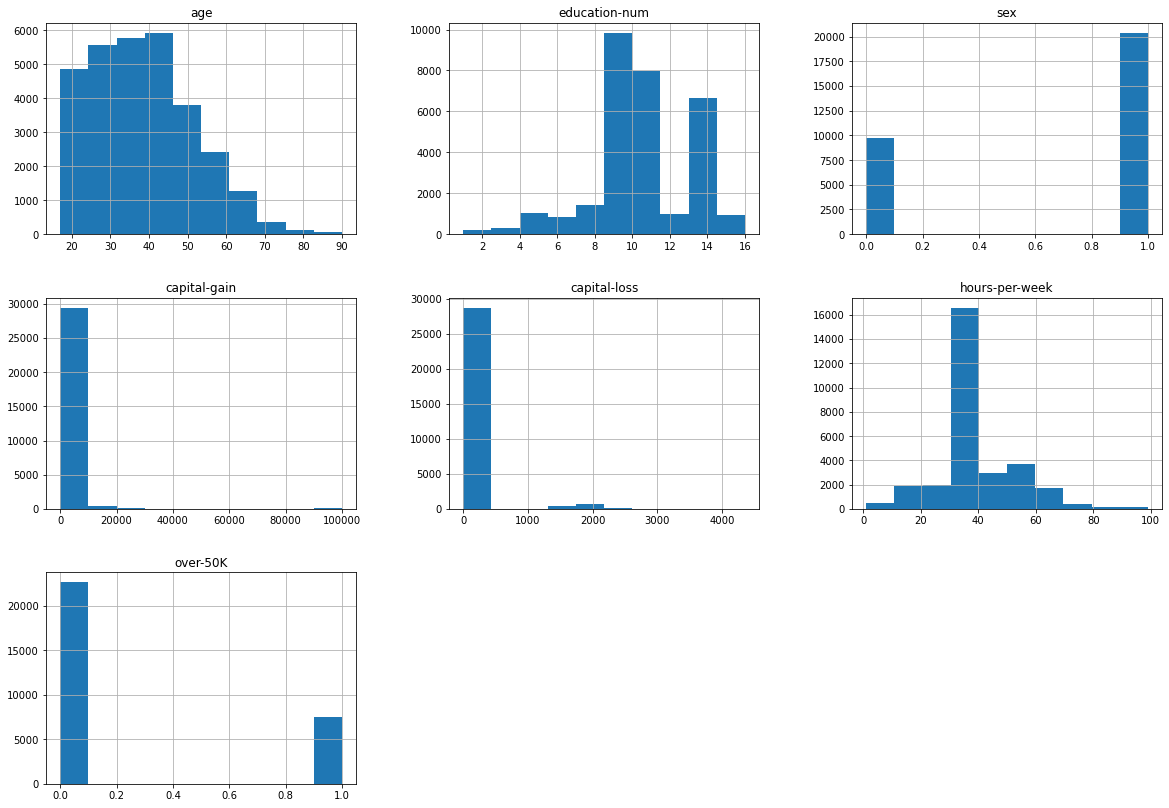

In [9]:
# Visualize age distribution
dataset1_train.age.plot(kind='kde')
plt.title('Age distribution')
plt.show()

# Visualize all numerical categories
dataset1_train.hist(figsize=(20, 14))

In [10]:
# Visualize categorical data
dataset1_train['education'].value_counts()
pd.crosstab(dataset1_train['education-num'], columns=dataset1_train['education'])
print(dataset1_train.shape)

# Remove education-num as it gives no more information than education
dataset1_train = dataset1_train.drop(columns='education-num')
dataset1_test = dataset1_test.drop(columns='education-num')
print(dataset1_train.shape)

(30162, 13)
(30162, 12)


## One-hot encoding

In [11]:
import category_encoders as ce

# Convert discrete variables into multiple variables using one-hot encoding
# Discrete columns: workclass, education, marital-status, occupation, relationship, sex, native-country
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital-status', 'occupation', 'race', 'relationship'], use_cat_names=True)
train_encoded_1 = encoder.fit_transform(dataset1_train)
test_encoded_1 = encoder.transform(dataset1_test) 

names_1_encoded = train_encoded_1.columns

ModuleNotFoundError: No module named 'category_encoders'

In [12]:
# Normalize
from sklearn import preprocessing

# Normalize training set
x = train_encoded_1.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1 = pd.DataFrame(x_scaled, columns=names_1_encoded)

# Normalize test set
x = test_encoded_1.values
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1_test = pd.DataFrame(x_scaled, columns=names_1_encoded)

NameError: name 'train_encoded_1' is not defined

# Experiments


## Cross Validation

In [ ]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

accuracy= lambda y, yh: np.mean(y==yh)

## KNN

In [ ]:
# Split the data
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()
x_normalized_train, x_normalized_test, y_normalized_train, y_normalized_test = train_test_split(x_normalized, y_normalized, test_size=0.15, shuffle=True)
print(x_normalized_train.shape, x_normalized_test.shape)
print(y_normalized_train.shape, y_normalized_test.shape)


(25637, 60) (4525, 60)
(25637,) (4525,)
(25637, 60) (4525, 60)
(25637,) (4525,)


In [ ]:
# Note: This code is inspired from the sklearn tutorial

n_neighbors = 1
knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors) # Initialize model
knn_model.fit(x_train, y_train)

# Predict
y_pred = knn_model.predict(x_train)
acc = np.mean(y_pred == y_train)

print(f'{acc:.4f}') # Should be 100%

0.9712


In [ ]:
# Cross validation

from sklearn.model_selection import cross_val_score
knn_model = neighbors.KNeighborsClassifier(n_neighbors=1)
scores    = cross_val_score(knn_model, x_train, y_train, cv=30)

print(f'averaged {scores.mean():.3f} ± {scores.std():.3f} over {scores.shape[0]} trials')

averaged 0.818 ± 0.010 over 30 trials


In [ ]:
best_acc = 0
for data, tag in zip((x_train, x_normalized_train), ('unnormalized', 'normalized')):

  for n_neighbors in np.arange(1,20):

    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    acc = cross_val_score(knn_model, data, y_train, cv=10).mean()

    if acc > best_acc:
      best_cfg = (tag, n_neighbors)
      best_acc = acc
      best_model = knn_model

print(f'best cross validation accuracy : {best_acc:.3f} found with config {best_cfg}')

best cross validation accuracy : 0.850 found with config ('unnormalized', 18)


In [ ]:
# (num_instances, num_features) = x_train.shape

# loss = lambda y, yh: np.mean((y-yh)**2)

# #Plot the mean square error for different K values stored in K_list
# K_list = range(1,30)
# err_train, err_test = [], []
# for i, K in enumerate(K_list):
#     model = neighbors.KNeighborsRegressor(n_neighbors=K)
#     model = model.fit(x_train, y_train)
#     err_test.append(loss(model.predict(x_test), y_test))
#     err_train.append(loss(model.predict(x_train), y_train))

# plt.plot(K_list, err_test, '-', label='unseen')
# plt.plot(K_list, err_train, '-', label='train')
# plt.legend()
# plt.xlabel('K (number of neighbours)')
# plt.ylabel('mean squared error')
# plt.show()

## Decision Tree

## Evaluating best split criterion without max depth limitation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

#Find best split criteria

def find_best_crit(n_val,x_rest,y_rest,x_test,y_test,title):
        criteria_list=["gini", "entropy"] 
        acc_train,acc_valid = np.zeros(len(criteria_list)), np.zeros((len(criteria_list), n_folds))

        model = tree.DecisionTreeClassifier()
        model = model.fit(x_rest, y_rest)
        acc_train[0]= accuracy(y_rest, model.predict(x_rest))


        for f, (tr, val) in enumerate(cross_validate(n_val, n_folds)):
                model = tree.DecisionTreeClassifier()
                model = model.fit(x_test[tr,:], y_test[tr])
                acc_valid[0,f] = accuracy(y_test[val], model.predict(x_test[val])) 


        model = tree.DecisionTreeClassifier(criterion="entropy")
        model = model.fit(x_rest, y_rest)
        acc_train[1]= accuracy(y_rest, model.predict(x_rest))

        for f, (tr, val) in enumerate(cross_validate(n_val, n_folds)):
                model = tree.DecisionTreeClassifier(criterion="entropy")
                model = model.fit(x_test[tr,:], y_test[tr])
                acc_valid[1,f] = accuracy(y_test[val], model.predict(x_test[val])) 



        x=[1,2]

        plt.subplot(1,2,1)
        plt.scatter(x,acc_train, label='training')
        plt.xlabel('Gini Index=1                Entropy=2')
        plt.ylabel('Accuracy')
        plt.title('Training')

        plt.subplot(1,2,2)
        plt.scatter(x,np.mean(acc_valid, axis=1),label='validation')
        #plt.errorbar(criteria_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
        plt.title('Validation')
        plt.xlabel('Gini Index=1                Entropy=2')
        plt.ylabel('Accuracy')

        plt.tight_layout(pad=5)
        plt.show()
        plt.title(title)

## Evaluating best max depth limitation with Gini index

In [ ]:
from sklearn import tree


#Find best max depth using Gini index

def find_maxD_gini(n_val,x_rest,y_rest,x_test,y_test,title):
    max_depth=range(4,8)

    acc_train,acc_valid = np.zeros(len(max_depth)), np.zeros((len(max_depth), n_folds))


    for i, d in enumerate(max_depth):
        #Find the validation errors for num_folds splits for a given max_depth
        model = tree.DecisionTreeClassifier(criterion='gini',max_depth=d)
        model = model.fit(x_rest, y_rest)
        acc_train[i]= accuracy(y_rest, model.predict(x_rest))
        for f, (tr, val) in enumerate(cross_validate(n_val, n_folds)):
            model = tree.DecisionTreeClassifier(criterion='gini',max_depth=d)
            model = model.fit(x_test[tr,:], y_test[tr])
            acc_valid[i, f] = accuracy(y_test[val], model.predict(x_test[val])) 
    
    plt.plot(max_depth, acc_train,  label='Train')
    plt.errorbar(max_depth, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.show()

## Evaluating best max depth limitation with Entropy 

In [ ]:
from sklearn import tree

#Find best max depth using Gini index

def find_minsamp_entropy(n_val,x_train,y_train,x_val,y_val,title):
    max_depth=range(4,8)

    acc_train,acc_valid = np.zeros(len(max_depth)), np.zeros((len(max_depth), n_folds))

    #Evaluating value for max depth
    for i, d in enumerate(max_depth):
        #Find the validation errors for num_folds splits for a max_depth
        model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
        model = model.fit(x_rest, y_rest)
        acc_train[i]= accuracy(y_rest, model.predict(x_rest))
        for f, (tr, val) in enumerate(cross_validate(n_val, n_folds)):
            model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
            model = model.fit(x_test[tr,:], y_test[tr])
            acc_valid[i, f] = accuracy(y_test[val], model.predict(x_test[val])) 
    
    plt.plot(max_depth, acc_train,  label='Train')
    plt.errorbar(max_depth, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.show()

## Evaluating the best minimum number of samples using Entropy

In [ ]:
#Find best min number of samples using Entropy

def find_minsamp_entrop(n_val,x_train,y_train,x_val,y_val,title):
    min_sample=range(3,8)

    acc_train,acc_valid = np.zeros(len(min_sample)), np.zeros((len(min_sample), n_folds))

    #Evaluating value for max depth
    for i, d in enumerate(min_sample):
        #Find the validation errors for num_folds splits for a max_depth
        model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
        model = model.fit(x_rest, y_rest)
        acc_train[i]= accuracy(y_rest, model.predict(x_rest))
        for f, (tr, val) in enumerate(cross_validate(n_val, n_folds)):
            model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
            model = model.fit(x_test[tr,:], y_test[tr])
            acc_valid[i, f] = accuracy(y_test[val], model.predict(x_test[val])) 
    
    plt.plot(min_sample, acc_train,  label='Train')
    plt.errorbar(min_sample, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.show()